# Shopee Product Classification 

Notebook to experiment over several Neural Networks over the product dataset obtained from Shopee and evaluate results.

The following models are evaluated as part of this notebook:

Baseline 1: CNN <br>
Baseline 2: CNN with augmented layers <br>
Improvement 1: Adding ANN <br>
Improvement 2: Adding RNN <br>

## Imports and Config

In [1]:
!pip install scikit-image
!pip install shopee_crawler
!pip install torchvision
!pip install opencv-python

  Using cached scikit_image-0.19.3-cp39-cp39-macosx_12_0_arm64.whl (12.5 MB)
  Using cached PyWavelets-1.4.1-cp39-cp39-macosx_11_0_arm64.whl (4.3 MB)
  Using cached tifffile-2022.10.10-py3-none-any.whl (210 kB)
  Using cached imageio-2.22.2-py3-none-any.whl (3.4 MB)
  Using cached networkx-2.8.7-py3-none-any.whl (2.0 MB)
  Using cached scipy-1.9.3-cp39-cp39-macosx_12_0_arm64.whl (28.6 MB)
  Using cached opencv_python-4.6.0.66-cp37-abi3-macosx_11_0_arm64.whl (30.0 MB)


In [1]:
import os
import sys
import json
import importlib
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import file_utils, dataset
from scripts import crawler

import ipywidgets as widgets

import cv2
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from torchvision import transforms, models, datasets


In [67]:
crawler

<module 'scripts.crawler' from 'C:\\Users\\admin\\Documents\\GitHub\\cs5242-project\\scripts\\crawler.py'>

In [38]:
# Can use this to reload file when editing for faster changes
importlib.reload(dataset)

<module 'utils.dataset' from '/Users/naomileow/Documents/school/CS5242/project/utils/dataset.py'>

## Data Load

In [2]:
image_dir = 'data/images'

In [115]:
if(file_utils.check_images_dir()):
    print(f'Images already exist at: {file_utils.images}')
elif(file_utils.check_tar_exists()):
    print(f'Images not yet extracted')
    print(f'Image zip exists at: {file_utils.images_zip}')
    file_utils.extract_tar()
else:
    print(f'Images need to be downloaded')
    for c in category_urls:
        get_category_data('data', c)
    download_images('data')

Images already exist at: data/images


## Note: To be in accordance with other folders, changes to make:
- Add "-cat" to Women's Apparel directory after unzipping (Maybe we handle when we're zipping itself? Otherwise we can add a condition for this in the dataloader too)

## Dataset

In [3]:
data = dataset.DataSet(max_num_img=300)

<BarContainer object of 24 artists>

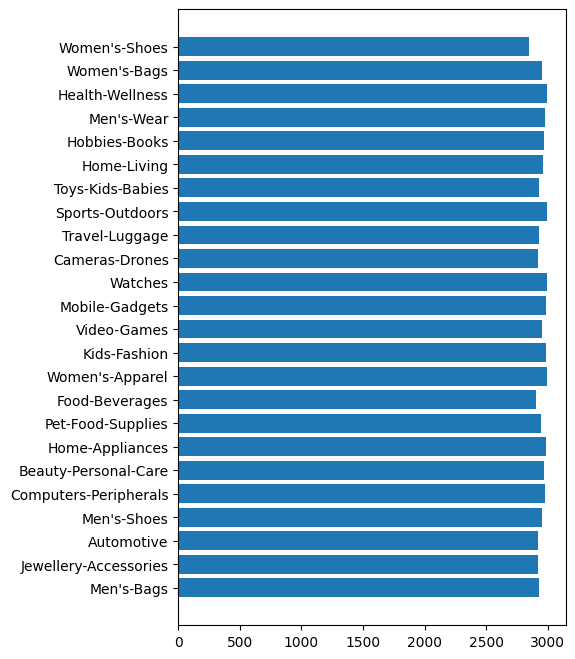

In [4]:
cats, items = zip(*data.image_count_per_category().items())
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(cats, items)

In [5]:
data.load_all()

100%|██████████| 300/300 [00:00<00:00, 441.49it/s]


In [16]:
all_categories = data.categories
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: data.plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=("Men's-Bags", 'Jewellery-Accessories', 'Automo…

In [17]:
#TODO: Check if need to normalize data or convert shapes
all_categories

["Men's-Bags",
 'Jewellery-Accessories',
 'Automotive',
 "Men's-Shoes",
 'Computers-Peripherals',
 'Beauty-Personal-Care',
 'Home-Appliances',
 'Pet-Food-Supplies',
 'Food-Beverages',
 "Women's-Apparel",
 'Kids-Fashion',
 'Video-Games',
 'Mobile-Gadgets',
 'Watches',
 'Cameras-Drones',
 'Travel-Luggage',
 'Sports-Outdoors',
 'Toys-Kids-Babies',
 'Home-Living',
 'Hobbies-Books',
 "Men's-Wear",
 'Health-Wellness',
 "Women's-Bags",
 "Women's-Shoes"]

In [23]:
cat_map = dict(zip(all_categories, range(0, len(all_categories))))
cat_map

{"Men's-Bags": 0,
 'Jewellery-Accessories': 1,
 'Automotive': 2,
 "Men's-Shoes": 3,
 'Computers-Peripherals': 4,
 'Beauty-Personal-Care': 5,
 'Home-Appliances': 6,
 'Pet-Food-Supplies': 7,
 'Food-Beverages': 8,
 "Women's-Apparel": 9,
 'Kids-Fashion': 10,
 'Video-Games': 11,
 'Mobile-Gadgets': 12,
 'Watches': 13,
 'Cameras-Drones': 14,
 'Travel-Luggage': 15,
 'Sports-Outdoors': 16,
 'Toys-Kids-Babies': 17,
 'Home-Living': 18,
 'Hobbies-Books': 19,
 "Men's-Wear": 20,
 'Health-Wellness': 21,
 "Women's-Bags": 22,
 "Women's-Shoes": 23}

# Prepare Train and Test Dataset

In [140]:
#Splitting on indices to get the set of images and labels
# indices = np.arange(len(data.images))
# train_data, test_data = train_test_split(all_data, test_size=0.2, random_state = 42)
# print(len(train_data))
# print(len(test_data))


# CNN Baseline Model

In [ ]:
from utils.train_utils import Trainer, get_device

model = models.resnet18(pretrained=True)
# model.classifier = nn.Sequential()
#for param in model.parameters():
#    param.requires_grad = False
device = get_device()
model.to(device)
# model.eval().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
batch_size=32
trainer = Trainer(model, optimizer, criterion, data, batch_size)

In [13]:
num_epoch = 10
trainer.run_train(num_epoch)

epoch   0 |   100 batches loss: 3.3738
[Epoch   0]: Training loss: 3.040059 | Accuracy: 0.218452
[Epoch   0]: Validation loss: 2.378174 | Accuracy: 0.301389
epoch   1 |   100 batches loss: 1.9047
[Epoch   1]: Training loss: 1.952146 | Accuracy: 0.428571
[Epoch   1]: Validation loss: 2.402557 | Accuracy: 0.319444
epoch   2 |   100 batches loss: 1.3410
[Epoch   2]: Training loss: 1.442472 | Accuracy: 0.568056
[Epoch   2]: Validation loss: 2.463995 | Accuracy: 0.345833
epoch   3 |   100 batches loss: 0.8255
[Epoch   3]: Training loss: 0.927367 | Accuracy: 0.719246
[Epoch   3]: Validation loss: 2.843816 | Accuracy: 0.309722
epoch   4 |   100 batches loss: 0.5097
[Epoch   4]: Training loss: 0.557648 | Accuracy: 0.826786
[Epoch   4]: Validation loss: 3.070482 | Accuracy: 0.334722
epoch   5 |   100 batches loss: 0.3480
[Epoch   5]: Training loss: 0.380898 | Accuracy: 0.883333
[Epoch   5]: Validation loss: 3.331883 | Accuracy: 0.320833
epoch   6 |   100 batches loss: 0.2365
[Epoch   6]: Traini

In [19]:
test_loss, test_acc, incorect_stats = trainer.run_test(trainer.testloader, True)
print(f'Accuracy of the network on the test images: {test_acc*100} %')

Accuracy of the network on the test images: 29.65277777777778 %


In [22]:
from collections import Counter

counts = Counter(incorect_stats).most_common(25)
for k, v in counts:
    print(f"({all_categories[k[0]]}, {all_categories[k[1]]}): {v}")

(Health-Wellness, Food-Beverages): 17
(Women's-Bags, Men's-Bags): 10
(Hobbies-Books, Food-Beverages): 10
(Mobile-Gadgets, Computers-Peripherals): 9
(Home-Living, Food-Beverages): 8
(Toys-Kids-Babies, Kids-Fashion): 8
(Women's-Apparel, Kids-Fashion): 8
(Cameras-Drones, Home-Appliances): 7
(Computers-Peripherals, Men's-Bags): 7
(Health-Wellness, Pet-Food-Supplies): 7
(Pet-Food-Supplies, Food-Beverages): 7
(Automotive, Home-Appliances): 7
(Beauty-Personal-Care, Health-Wellness): 7
(Travel-Luggage, Women's-Bags): 7
(Automotive, Women's-Bags): 7
(Home-Appliances, Computers-Peripherals): 7
(Home-Living, Computers-Peripherals): 7
(Automotive, Home-Living): 7
(Computers-Peripherals, Mobile-Gadgets): 7
(Travel-Luggage, Men's-Bags): 6
(Men's-Bags, Women's-Bags): 6
(Jewellery-Accessories, Travel-Luggage): 6
(Home-Living, Jewellery-Accessories): 6
(Women's-Shoes, Watches): 6
(Women's-Shoes, Men's-Shoes): 6
